- Ask yourself why would they have selected this problem for the challenge? What are some gotchas in this domain I should know about?
- Which modeling techniques are good at capturing the types of relationships I see in this data?
- Now that I have a model, how can I be sure that I didn't introduce a bug in the code? If results are too good to be true, they probably are!
- What are some of the weaknesses of the model and and how can the model be improved with additional work
- Suggest ways in which you can improve the model.

## Frame the Problem

- This is an IMDB dataset having 50K movie reviews for natural language processing.- It is a  binary sentiment classificatios.It consists ofaa  set of 25,000positive and 25,000 negative reviews..

## Objective

- The objective is to predict the number of positive and negative reviews using either classification or deep learning algorithms.

## Top Solution

The highest level of accuracy achieved with this dataset is 96.21 Accuracy in the [XLNet: Generalized Autoregressive Pretraining for Language Understanding](https://paperswithcode.com/sota/sentiment-analysis-on-imdb) paper

## Performance Measure

## Data Source
https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data

## Constants

In [1]:
DATA_PATH = '../Data/Raw/IMDB Dataset.csv'
PREPROCESSED_PATH = "../Data/Processed/preprocessed_df.pkl"
ENGINEERED_PATH = "../Data/Processed/engineered_df.pkl"

MLFLOW_TRACKING_URI = '../Models/mlruns'
MLFLOW_EXPERIMENT_NAME = "imdb_review_sentiment_analysis"
LOG_PATH = "../Models/temp/"
LOG_DATA_PKL    =  "data.pkl"
LOG_MODEL_PKL   =  "model.pkl"
LOG_METRICS_PKL =  "metrics.pkl"

## Packages

In [100]:
import os
import numpy as np
import pandas as pd

import logging
import pickle
from pathlib import Path

import re
import nltk
import string
import spacy
import scipy.stats as stats
from nltk.tag import pos_tag
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler,RobustScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score,ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate,cross_val_predict, GridSearchCV, RandomizedSearchCV

import mlflow
from mlflow.tracking import MlflowClient


# pd.options.display.max_rows = 10000
# pd.options.display.max_columns = 10000

## Functions

In [3]:
# Create a Folder named Images to save figures in.
IMAGES_PATH = Path.cwd().parent / "Images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """
    This functions will save the current figure shown below.
    
    Args:
        fig_id: String Containing the name of the figure.
        tight_layout: Boolean to decide whether you want a tight layout or not.
        fig_extension: String to decide the type of the figure.
        resoultion: Int to decide the resolution of the figure.
        
    Returns:
        None
    """
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    
    if tight_layout:
        plt.tight_layout()
        
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
# Function to log Data, Model, Metrics and Track models.
def log_data(x_train,y_train,x_test,y_test):
    # Save the model's dataset trained on
    data_details = {
                    "x_train": x_train,
                    "x_test": x_test,
                    "y_train": y_train,
                    "y_test": y_test
    }

    with open(os.path.join(LOG_PATH, LOG_DATA_PKL), "wb") as output_file:
        pickle.dump(data_details, output_file)
        
        
def log_model(clf,model_description=''):
    # save the model, model details and model's description
    model = {"model_description": model_description,
             "model_details": str(clf),
             "model_object": clf} 

    with open(os.path.join(LOG_PATH, LOG_MODEL_PKL), "wb") as output_file:
        pickle.dump(model, output_file)
        
    return model
        
def log_metrics(train_scores, test_scores):
    # save the model metrics
    classes_metrics = {"train_scores": train_scores,
                        "test_scores" : test_scores} 


    with open(os.path.join(LOG_PATH, LOG_METRICS_PKL), "wb") as output_file:
        pickle.dump(classes_metrics, output_file)

def track_model(model, scores):
    # Start a run in the experiment and track current model
    with mlflow.start_run(experiment_id=exp.experiment_id, run_name=model["model_description"]):
        # Track pickle files
        mlflow.log_artifacts(LOG_PATH)

        # Track metrics 
        for metric, score in scores.items():
            mlflow.log_metric(metric, score)

In [5]:
# count number of characters 
def chars_count(text):
    return len(text)

In [6]:
# count number of words 
def words_count(text):
    return len(text.split())

In [7]:
# count number of capital words
def capital_words_count(text):
    return sum(map(str.isupper,text.split()))

In [8]:
# count number of punctuations
def punctuations_count(text):
    punctuations='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    d=dict()
    for i in punctuations:
        d[str(i)+' count']=text.count(i)
    return d

In [9]:
# count number of words in quotes
def words_in_quotes_count(text):
    x = re.findall("\'.\'|\".\"", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

In [10]:
# count number of sentences
def sent_count(text):
    return len(sent_tokenize(text))

In [11]:
# count number of unique words 
def unique_words_count(text):
    return len(set(text.split()))

In [12]:
# count of stopwords
def stopwords_count(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

In [13]:
# visualize Box plot and KDE plot
def visualize_features(col, legend):

    plt.rcParams["figure.figsize"] = [12, 4]
    plt.rcParams["figure.autolayout"] = True
    f, axes = plt.subplots(1, 2)
    sns.boxplot(x=col, hue=legend, ax=axes[0])
    sns.kdeplot(x=col, hue=legend, ax=axes[1])
    plt.legend(legend.unique())
    axes[0].set_xlabel(f'{col.name[1]} Box Plot')
    axes[1].set_xlabel(f'{col.name[1]} KDE Plot')
    plt.ylabel('')
    plt.suptitle(col.name[1])
    # Save the figure
    save_fig(f'2-{col.name[1]} Box plot and KDE plot')
    plt.show()

In [14]:
# Create n_grams
def create_ngrams(text, n=2):
    text = str(text)
    n_grams = ngrams(text.split(), n)
    returnVal = []
    try:
        for grams in n_grams:
            returnVal.append('_'.join(grams))
    except(RuntimeError):
        pass
    return ' '.join(returnVal).strip()

In [15]:
# Create a wordcloud
def create_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=30,
        scale=3,
        random_state=42)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

In [16]:
# pLot bar plot of top n words in a col 
def plot_most_common_words(col,n):

    # Get the vocab in each row
    vocab = col.str.split().values.tolist()
    # Create the corpus of the whole column
    corpus=[word for line in vocab for word in line]

    # Get the most common n words
    counter=Counter(corpus).most_common(n)
    word = []
    count = [] 
    for i, j in counter:
        word.append(i)
        count.append(j)

    # define Seaborn color palette 
    palette_color = sns.color_palette("rocket", n)
    # Set the fig size
    plt.figure(figsize=(10, 10))
    sns.barplot(x= count, y= word)
    plt.title(f'{n} most common words in {col.name} column')
    # Save the figure
    save_fig(f'3-{n} most common words in {col.name} column')
    plt.show()

In [17]:
# GEt pos_tags from the dataset
def pos_tags(df, col, sample):
    # sample data
    df = df.head(sample)
    # create tokens
    tokens = word_tokenize(" ".join(df[col].values.tolist()))
    # create tags
    tags = pos_tag(tokens, tagset = "universal",lang='eng')
    return tags

In [18]:
def get_most_common_pos(tags, pos, tag_count):
    # Get all tokens that are tagged as tags
    tags_list = [word for word, tag in tags if tag == pos]
    # Count most common adjectives
    most_common = Counter(tags_list).most_common(tag_count)
    # word and frequency
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)
    return words, frequency

In [19]:
def measure_polarity(text):
    
    def _polarity(text):
        return TextBlob(text).sentiment.polarity
        
    polarity_score =text.apply(lambda x : _polarity(x))
    return polarity_score

## Load Dataset

In [18]:
# Read Dataset and print shape
raw_df = pd.read_csv(DATA_PATH)
raw_df.shape

(50000, 2)

## Data Preprocessing

In [17]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


- The Dataset contains only two columns
- Review column is the training data and Sentiment is the labels column
- The dataset doesn't have null values

In [18]:
# Check for Duplicates
raw_df.duplicated().value_counts()

False    49582
True       418
dtype: int64

- The Dataset Contains 418 Duplicated samples

In [19]:
# Remove the Duplicates
raw_df = raw_df.drop_duplicates()

In [20]:
# Check whether the dataset is balanced or imbalanced?
raw_df['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

- The Dataset is Balanced

In [21]:
# Check whether any empty reviews exist
raw_df['length'] = raw_df['review'].apply(len)
print(len(raw_df[raw_df['length'] == 0]))
raw_df = raw_df.drop(columns='length')

0


- The Dataset doesn't have empty reviews

### Text preprocessing

In [22]:
df = raw_df.copy()

In [23]:
# Convert text to lowercase
raw_df['review_cleaned'] = raw_df['review'].str.lower()

In [24]:
# Remove HTML tags
raw_df['review_cleaned'] = raw_df['review_cleaned'].apply(lambda x: re.sub('<[^<]+?>', ' ', x))

In [25]:
# Remove Punctuations
# raw_df['review'] = raw_df['review'].str.translate(str.maketrans('', '', string.punctuation))
raw_df['review_cleaned'] = raw_df['review_cleaned'].apply(lambda x: re.sub(f"[{re.escape(string.punctuation)}]",' ', x))

In [26]:
# Remove Digits
raw_df['review_cleaned'] = raw_df['review_cleaned'].apply(lambda x: re.sub(r'\d+', '', x))

In [27]:
# Remove URLs
raw_df['review_cleaned'] = raw_df['review_cleaned'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x))

In [28]:
# Create new column with No StopWords
stop_words = stopwords.words('english')
raw_df['review_nostopwords'] = raw_df['review_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [29]:
# Create new column for stemmed words
stemmer = PorterStemmer()
raw_df["review_stemmed"] = raw_df["review_nostopwords"].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

In [30]:
# Create new column for lemmatized words 
#Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")
# Process the text using spaCy and Extract lemmatized tokens
raw_df['review_lemma'] = raw_df["review_nostopwords"].apply(lambda x: " ".join([word.lemma_ for word in nlp(x)]))

- Applying Text preprocessing in that specific order resulted in the most clean Dataset

In [79]:
# Verify your Results
i = df.sample(1).index[0]
# i = 100
print(raw_df['review_stemmed'].iloc[i])
print('###########################################################')
print(df['review'].iloc[i])

one film rememb year anyth happen w think terribl realli good either alec baldwin pretti good plot kind flimsi best cast pretti good given good script baldwin direct although could sworn direct thought read somewher lot shoot bad definit potenti although work rock noth short geniu keep busi littl longer hope show bow grace la seinfeld mayb even long year went want see film get much realli hate either well rememb last time film wrap long final releas dvd nice see alec baldwin anthoni hopkin togeth sinc excel yet much peopl seen edg pick excel film real entertain
###########################################################
This is one of those films that I remember being in the can for years before anything happening w/it. I don't think it's terrible, but it's not really good either. Alec Baldwin was pretty good, but the plot is it kind of flimsy at best. The cast is pretty good in what they're given, but again you are only as good as the script. Baldwin directing this although I could ha

In [32]:
# Export the preprocessed dataset with pickle
raw_df.to_pickle(PREPROCESSED_PATH)

In [20]:
prep_df = pd.read_pickle(PREPROCESSED_PATH).reset_index(drop=True)

## Feature Engineering

In [5]:
featured_df = prep_df.copy()

In [179]:
# Add a char count feature
featured_df['char_count'] = prep_df['review_cleaned'].apply(lambda x: chars_count(x))

In [180]:
# Add a word count feature
featured_df['word_count'] = prep_df['review_cleaned'].apply(lambda x: words_count(x))

In [181]:
# Add a sentence count feature
featured_df['sent_count'] = prep_df['review'].apply(lambda x: sent_count(x))

In [182]:
# Add a feature for the count of capital characters 
featured_df['capital_char_count'] = prep_df['review'].apply(lambda x: capital_words_count(x)) 

In [183]:
# Add a feature for the count of words in quotes
featured_df['words_in_quotes_count'] = prep_df['review'].apply(lambda x: words_in_quotes_count(x))

In [184]:
# Add a feature for the count of stopwords
featured_df['stopwords_count'] = prep_df['review'].apply(lambda x: stopwords_count(x))

In [185]:
# Add a feature for the count of unique words
featured_df['unique_words_count'] = prep_df['review_nostopwords'].apply(lambda x: unique_words_count(x))

In [186]:
# Add a punctuations count feature
featured_df['punctuations_count'] = prep_df['review'].apply(lambda x: punctuations_count(x))

In [187]:
# Add Average word length feature
featured_df['avg_word_len'] = featured_df['char_count'] / featured_df['word_count']

In [188]:
# Add Average sentence length feature
featured_df['avg_sent_len'] = featured_df['word_count'] / featured_df['sent_count']

In [189]:
# Add unique words percentage feature
featured_df['unique_words_percent'] = featured_df['unique_words_count'] / featured_df['word_count']

In [190]:
# Add a stopwords percentage feature
featured_df['stopwords_percent'] = featured_df['stopwords_count'] / featured_df['word_count']

In [191]:
featured_df = featured_df.drop(columns=prep_df.columns)

In [192]:
punct_cols = pd.DataFrame(list(featured_df.punctuations_count))
punct_cols.columns = pd.MultiIndex.from_product([['punct_cols'], punct_cols.columns])

In [193]:
featured_df = featured_df.drop('punctuations_count', axis=1)

In [194]:
featured_df.columns = pd.MultiIndex.from_product([['featured_cols'], featured_df.columns])

In [195]:
featured_df= pd.concat([featured_df,punct_cols],axis=1)

In [133]:
## Add the polarity score feature, This is done after EDA
featured_df['featured_cols','polarity'] = measure_polarity(prep_df['review_nostopwords'])

In [136]:
featured_df = featured_df.drop('polarity', axis = 1,level = 0)

In [140]:
# Export the preprocessed dataset with pickle
featured_df.to_pickle(ENGINEERED_PATH)

In [21]:
featured_df = pd.read_pickle(ENGINEERED_PATH)

## Exploratory Data Analysis

In [19]:
temp_df = prep_df.copy()

In [21]:
featured_df.describe()

featured_cols                                                 \
         char_count    word_count    sent_count capital_char_count   
count  49582.000000  49582.000000  49582.000000       49582.000000   
mean    1287.111976    234.348877     10.741519           4.857549   
std      972.994934    173.721367      7.817026           5.635247   
min       32.000000      6.000000      1.000000           0.000000   
25%      689.000000    128.000000      6.000000           1.000000   
50%      954.000000    176.000000      9.000000           3.000000   
75%     1561.000000    284.000000     13.000000           6.000000   
max    13589.000000   2492.000000    282.000000         162.000000   

                                                                              \
      words_in_quotes_count stopwords_count unique_words_count  avg_word_len   
count          49582.000000    49582.000000       49582.000000  49582.000000   
mean               0.020128       98.957686          97.048122      5.464315   
std                0.182088       74.692436          65.893968      0.351750   
min                0.000000        0.000000           3.000000      4.263158   
25%                0.000000       53.000000          55.000000      5.257732   
50%                0.000000       75.000000          75.000000      5.450746   
75%                0.000000      120.000000         119.000000      5.656716   
max                9.000000     1059.000000         864.000000     41.375000   

                                          ...    punct_cols                \
       avg_sent_len unique_words_percent  ...       [ count       \ count   
count  49582.000000         49582.000000  ...  49582.000000  49582.000000   
mean      25.207269             0.429043  ...      0.004820      0.000706   
std       21.183457             0.059976  ...      0.102395      0.033899   
min        0.056738             0.032558  ...      0.000000      0.000000   
25%       16.153846             0.388396  ...      0.000000      0.000000   
50%       21.000000             0.425111  ...      0.000000      0.000000   
75%       27.571429             0.465517  ...      0.000000      0.000000   
max      731.000000             0.840000  ...      6.000000      4.000000   

                                                                             \
            ] count       ^ count       _ count       ` count       { count   
count  49582.000000  49582.000000  49582.000000  49582.000000  49582.000000   
mean       0.005123      0.001916      0.020108      0.036868      0.003872   
std        0.104814      0.074720      0.864198      0.563733      0.096453   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        6.000000      6.000000    135.000000     24.000000      5.000000   

                                                 
            | count       } count       ~ count  
count  49582.000000  49582.000000  49582.000000  
mean       0.000908      0.003872      0.004639  
std        0.081948      0.097492      0.101910  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000  
max       12.000000      5.000000     11.000000  

[8 rows x 43 columns]

### What is the correlation between the sentiment and engineered features?

In [106]:
# Convert the sentiments to integer labels
temp_df['labels'] = temp_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [23]:
# Since we are dealing with independent Continuous features and dependent Categorical features
# We will use the point_biserial correlation

#calculate point-biserial correlation
corr = featured_df['featured_cols'].corrwith(temp_df['labels'].astype('float'), method=stats.pointbiserialr)
corr.rename(index={0: 'Correlation', 1: 'P_value'}, inplace=True)
corr = corr.style.format('{:.5f}')
corr

,char_count,word_count,sent_count,capital_char_count,words_in_quotes_count,stopwords_count,unique_words_count,avg_word_len,avg_sent_len,unique_words_percent,stopwords_percent
Correlation,0.01674,0.00914,-0.03721,-0.05181,-0.01326,0.00740,0.01584,0.07253,0.03836,0.03031,-0.00639
P_value,0.00019,0.04180,0.00000,0.00000,0.00314,0.09944,0.00042,0.00000,0.00000,0.00000,0.15475


- There is no Correlation between the newly created features and labels
- However all features are statistically significant except `stopwords_count` and `stopwords_percent`

In [24]:
#calculate point-biserial correlation
corr = featured_df['punct_cols'].corrwith(temp_df['labels'].astype('float'), method=stats.pointbiserialr)
corr.rename(index={0: 'Correlation', 1: 'P_value'}, inplace=True)
corr = corr.style.format('{:.5f}')
corr

,! count,""" count",# count,$ count,% count,& count,' count,( count,) count,* count,+ count,", count",- count,. count,/ count,: count,; count,< count,= count,> count,? count,@ count,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
Correlation,-0.01678,-0.02074,-0.00244,-0.04481,-0.01296,-0.01845,-0.04221,0.02655,0.02156,-0.03105,0.00566,0.03734,-0.01419,-0.03525,-0.02175,-0.01687,0.02179,-0.02275,0.00245,-0.02273,-0.17089,-0.00180,0.00317,0.00171,0.00482,0.00179,0.00442,-0.00933,0.01825,-0.00029,0.01888,-0.00650
P_value,0.00019,0.00000,0.58720,0.00000,0.00391,0.00004,0.00000,0.00000,0.00000,0.00000,0.20728,0.00000,0.00158,0.00000,0.00000,0.00017,0.00000,0.00000,0.58480,0.00000,0.00000,0.68782,0.48002,0.70391,0.28319,0.68967,0.32535,0.03770,0.00005,0.94893,0.00003,0.14756


- For the punctuation columns, only the `? col` have a slightly negative correlation
- There are some features that aren't statistically significant

### What is the correlation between the engineered features?

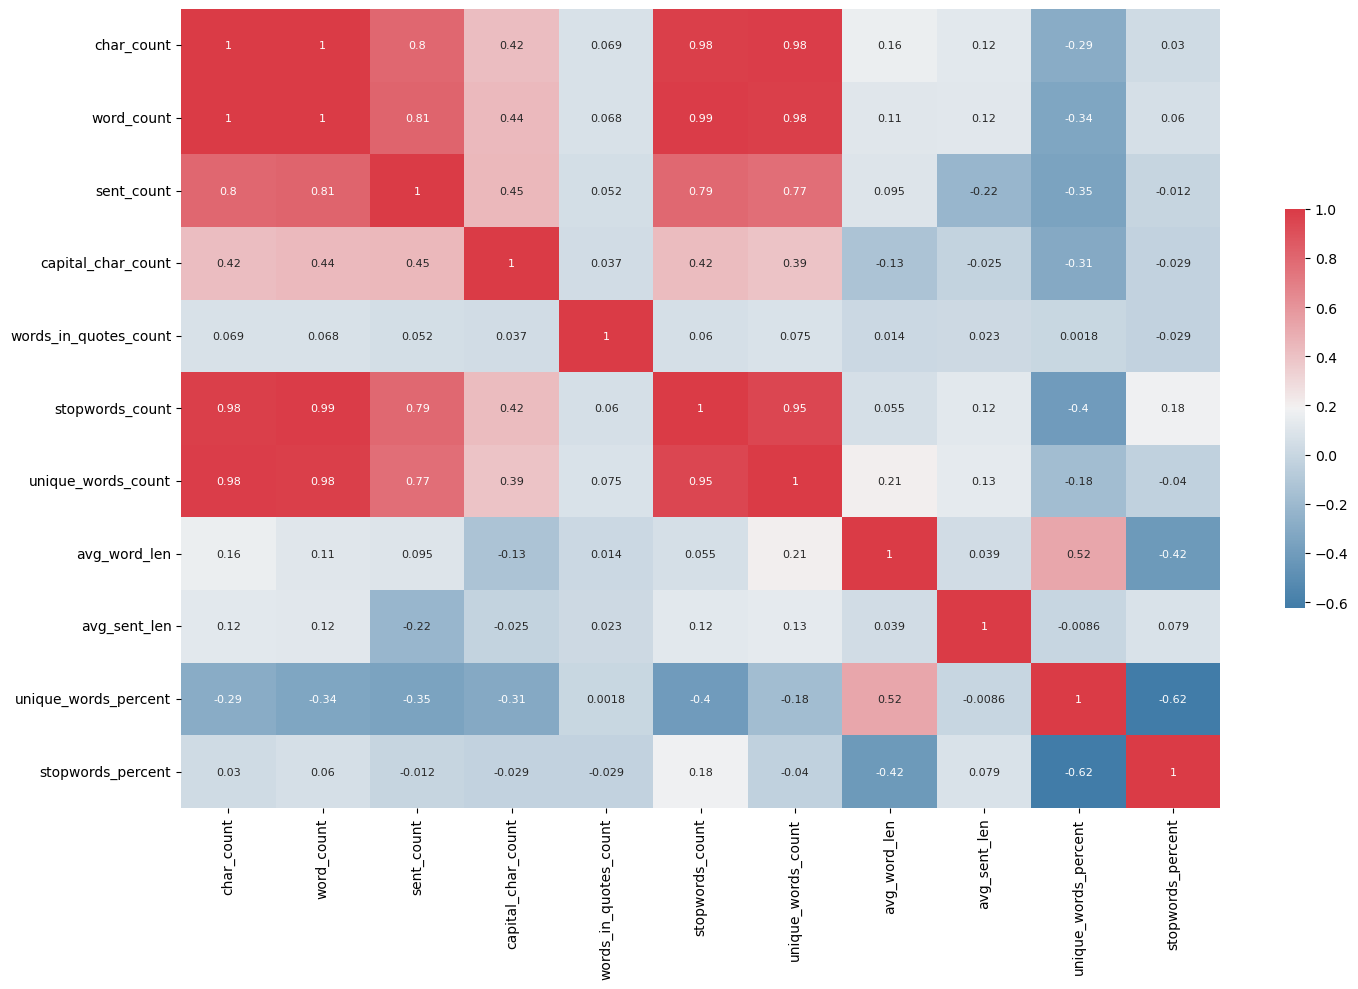

In [25]:
corr = featured_df['featured_cols'].corr(numeric_only= True)
# plot the heatmap

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr, 
            cmap=sns.diverging_palette(240, 10, as_cmap=True),                        
            cbar_kws={"shrink": .5}, annot=True,annot_kws={"fontsize":8}
            )
# Save the figure
save_fig('1-new_features_correlation')
plt.show()

- Some features are highly correlated, might be useful to get rid of some of them to avoid multicollinearity

### What is the distribution of the newly created features?

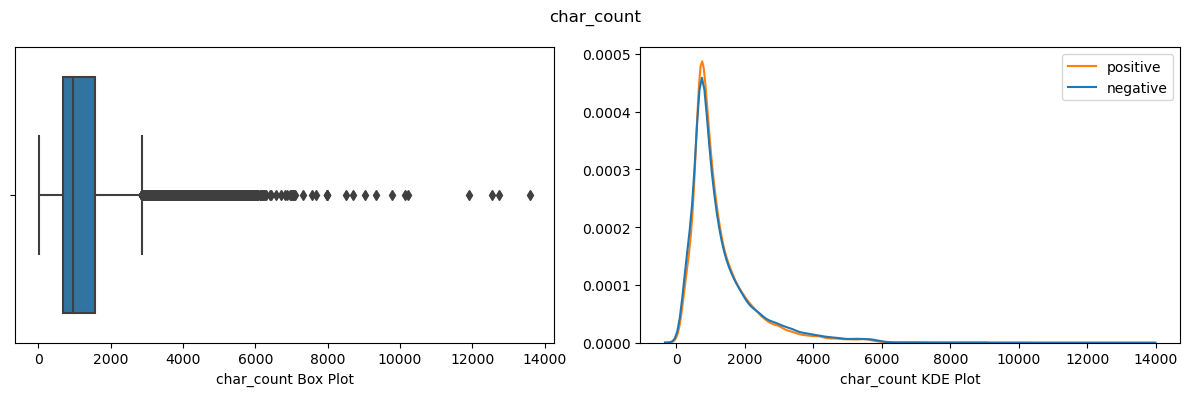

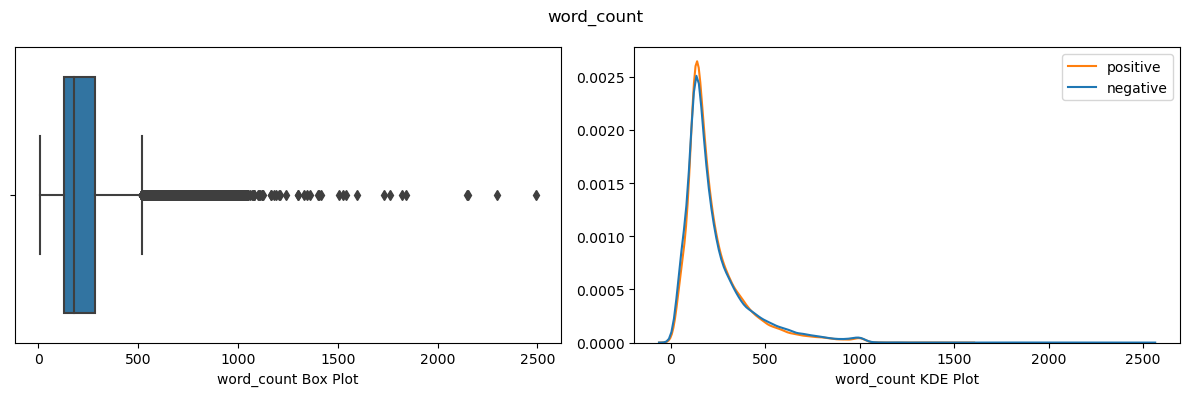

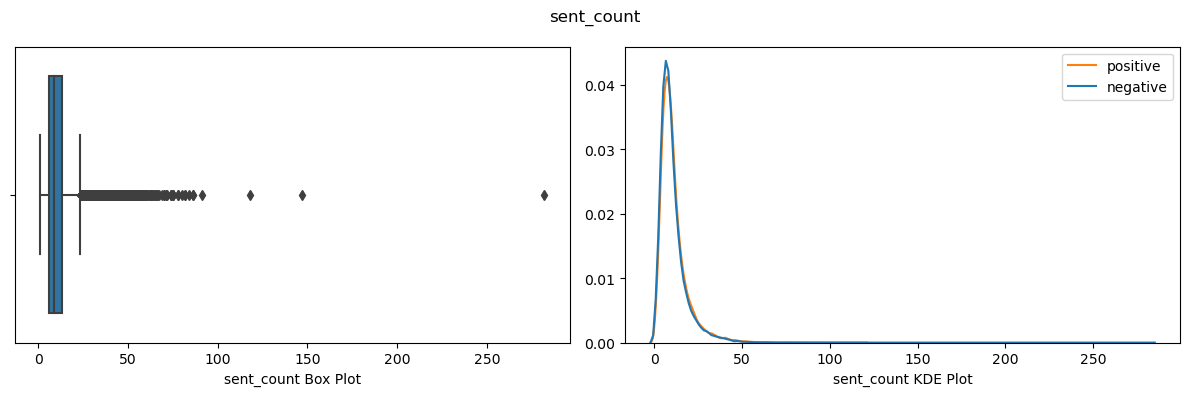

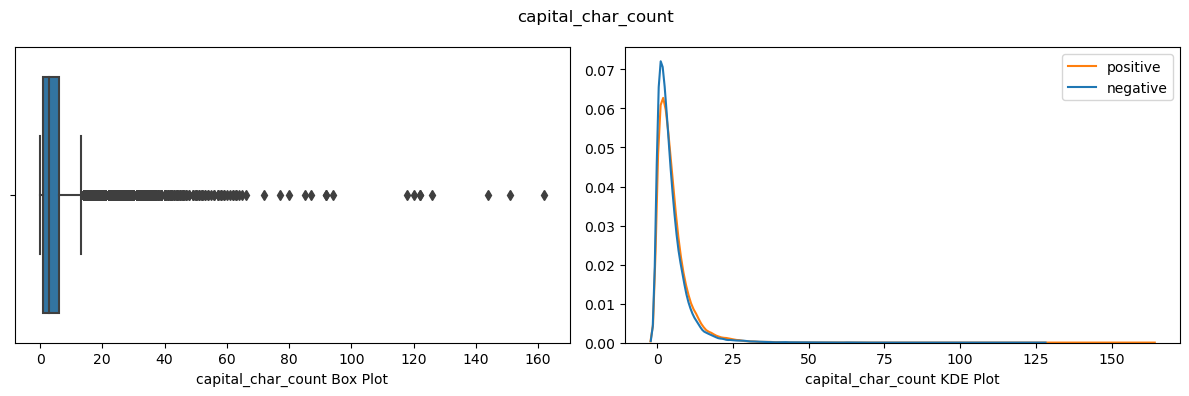

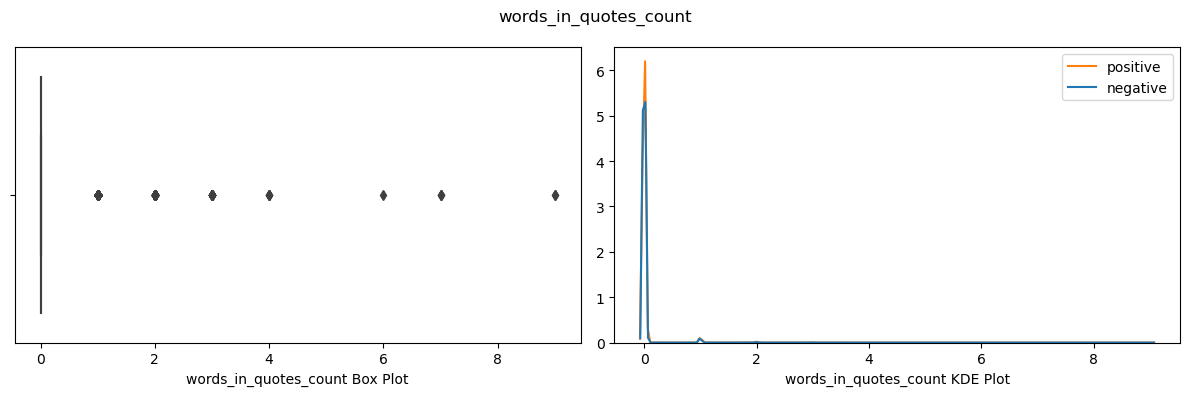

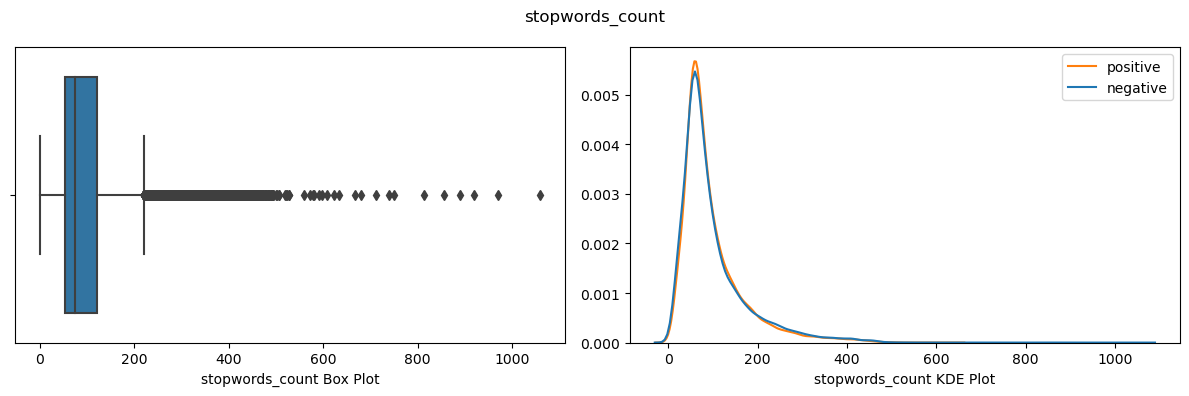

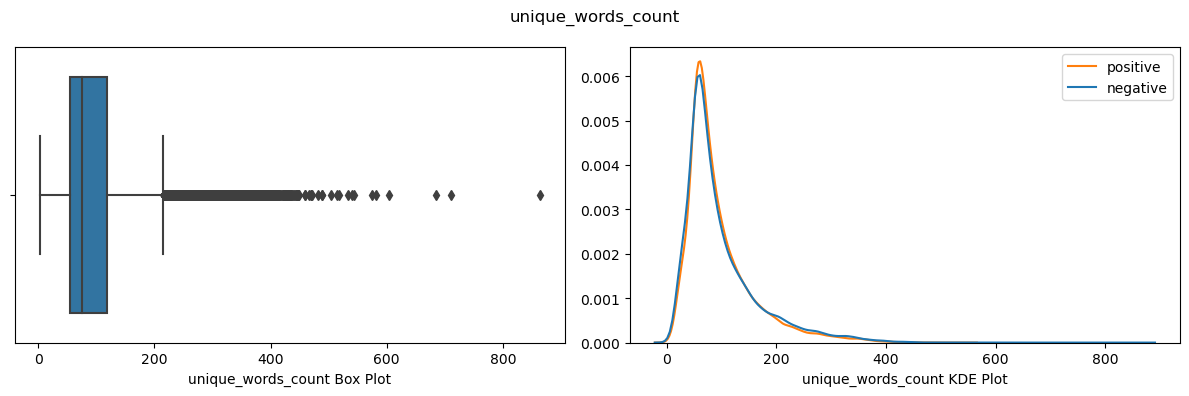

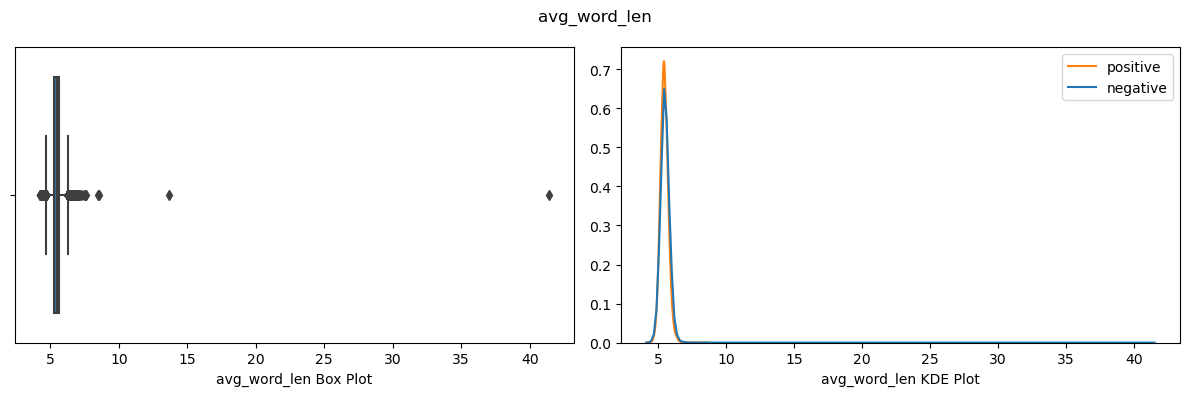

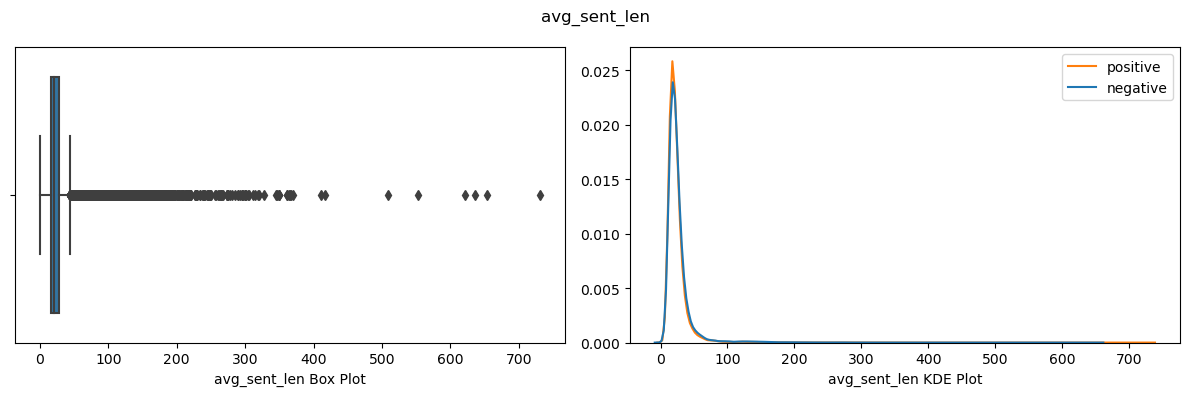

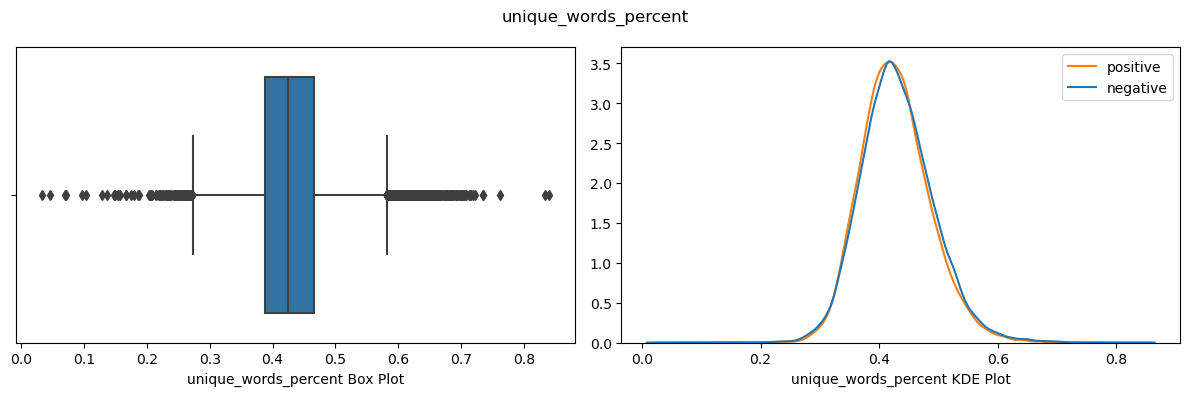

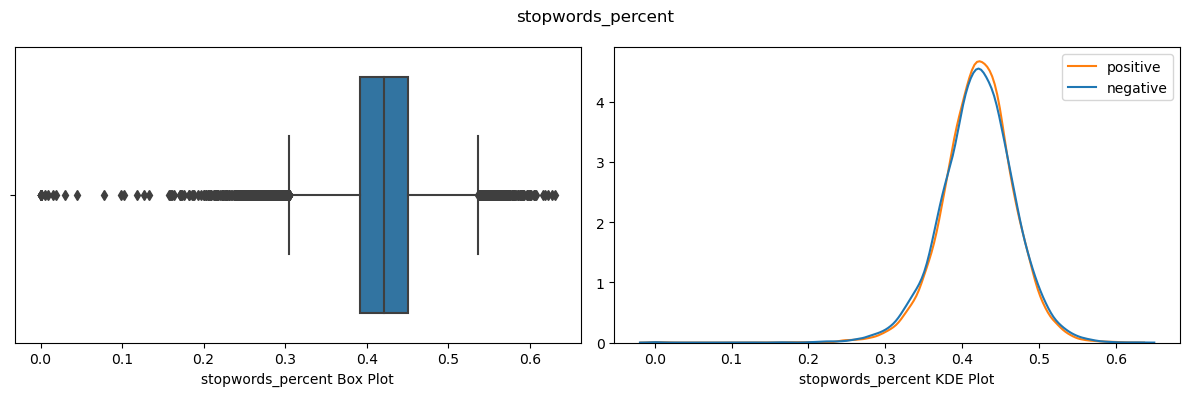

In [31]:
# Plot the Box plot and KDE plot 
cols = featured_df['featured_cols'].columns.tolist()
for col in cols:
    visualize_features(featured_df['featured_cols', col], temp_df['sentiment'])

- Both Positive and Negative sentiments have the same density distribution
- The new features seems to be heavily skewed.

### What are the values of skewness and kurtosis for newly created features?

In [31]:
# Calculate Skewness and Kurtosis.
cols = featured_df['featured_cols'].columns.tolist()
for col in cols:
    print(f"Feature: {col}")
    print(f"Skew: {featured_df['featured_cols', col].skew()}")
    print(f"Kurtosis: {featured_df['featured_cols', col].kurtosis()}")
    print("#################################################")

Feature: char_count
Skew: 2.189263323444492
Kurtosis: 6.831092207783385
#################################################
Feature: word_count
Skew: 2.167070473629442
Kurtosis: 6.753309188590938
#################################################
Feature: sent_count
Skew: 3.168110512023866
Kurtosis: 39.454926718486476
#################################################
Feature: capital_char_count
Skew: 4.925285991705652
Kurtosis: 65.78933424876463
#################################################
Feature: words_in_quotes_count
Skew: 16.29109430048798
Kurtosis: 477.14334654503494
#################################################
Feature: stopwords_count
Skew: 2.190433725037701
Kurtosis: 7.016818573870889
#################################################
Feature: unique_words_count
Skew: 1.895806040891379
Kurtosis: 4.6871937627502405
#################################################
Feature: avg_word_len
Skew: 21.932964055474947
Kurtosis: 2196.645425224072
####################################

- The new features are positively skewed with relatively many data on the tails

### What are the most common words and sentences in review?

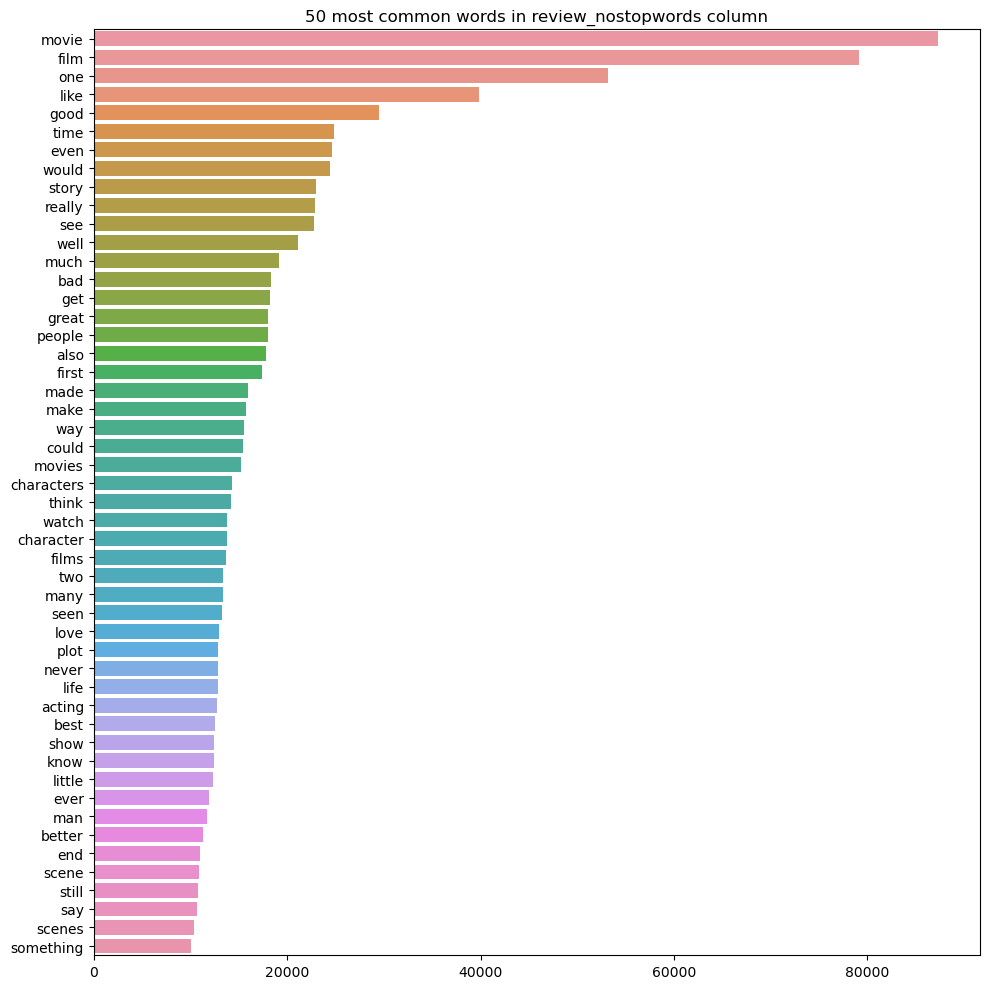

In [51]:
# Plot the most common 50 unigram words in the dataset
plot_most_common_words(temp_df['review_nostopwords'], 50)

- There is not much information we gained from except we can highlight some few words like: `good`, `bad`, `great`, `love`, `best`
- Let's try using N-grams to get more squences of words to gain more context from the data

In [55]:
# create n-grams for analysis
temp_df["bigram_text"] = temp_df['review_nostopwords'].apply(create_ngrams, n=2)
temp_df["trigram_text"] = temp_df['review_nostopwords'].apply(create_ngrams, n=3)
temp_df["quadgram_text"] = temp_df['review_nostopwords'].apply(create_ngrams, n=4)

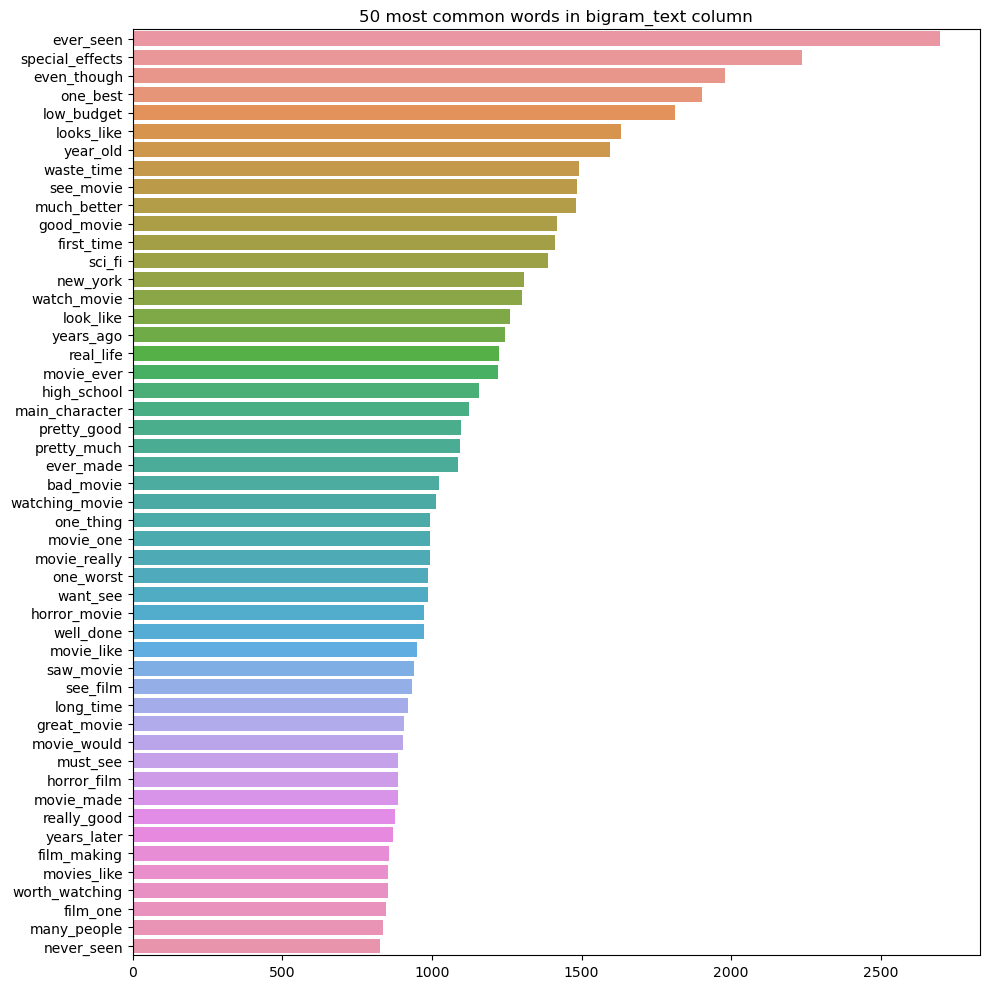

In [52]:
# Plot the most common 50 bigram words in the dataset
plot_most_common_words(temp_df['bigram_text'], 50)

- The bigram offers more context than the unigram but still not that meaningful

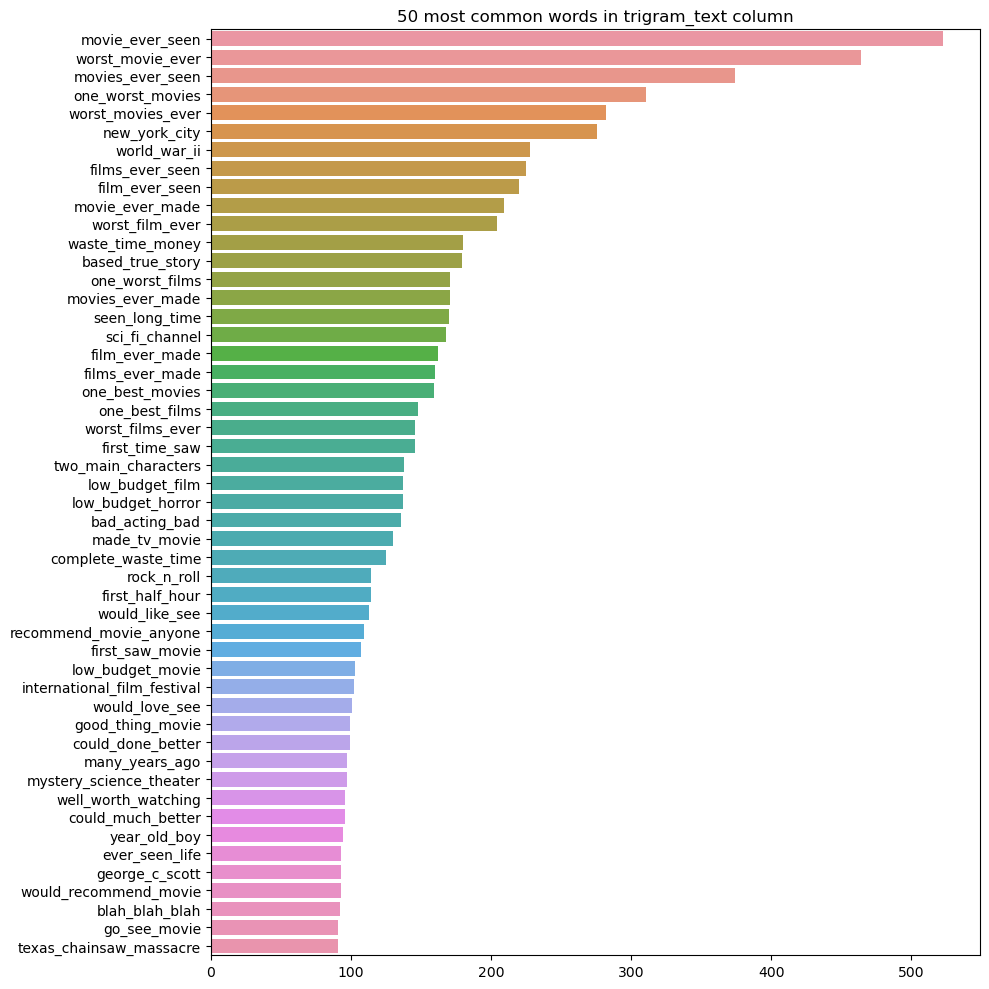

In [56]:
# Plot the most common 50 trigram words in the dataset
plot_most_common_words(temp_df['trigram_text'], 50)

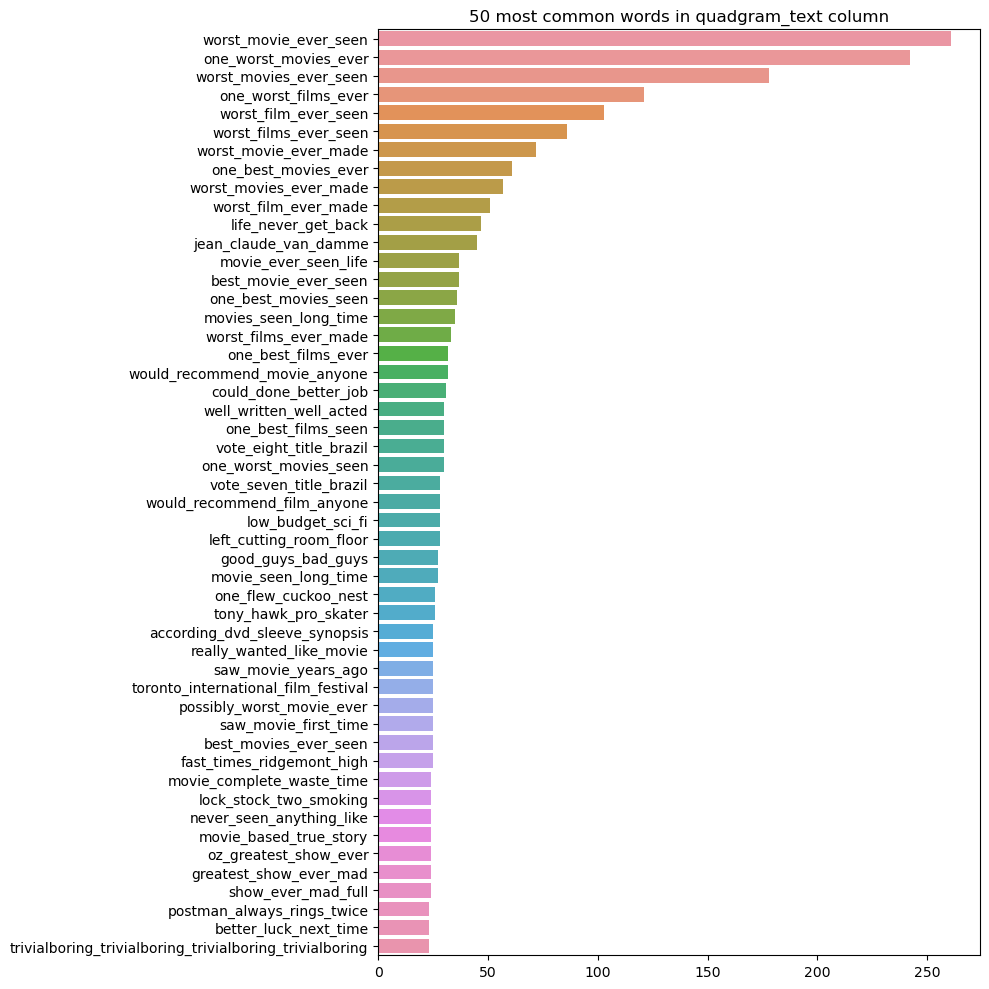

In [57]:
# Plot the most common 50 quadgram words in the dataset
plot_most_common_words(temp_df['quadgram_text'], 50)

- The trigram and quadgram offers more context and could identify whether the review was positive or negative

### What is the most common words used in each part of speech?

In [85]:
tags = pos_tags(temp_df, 'review_nostopwords',5000)

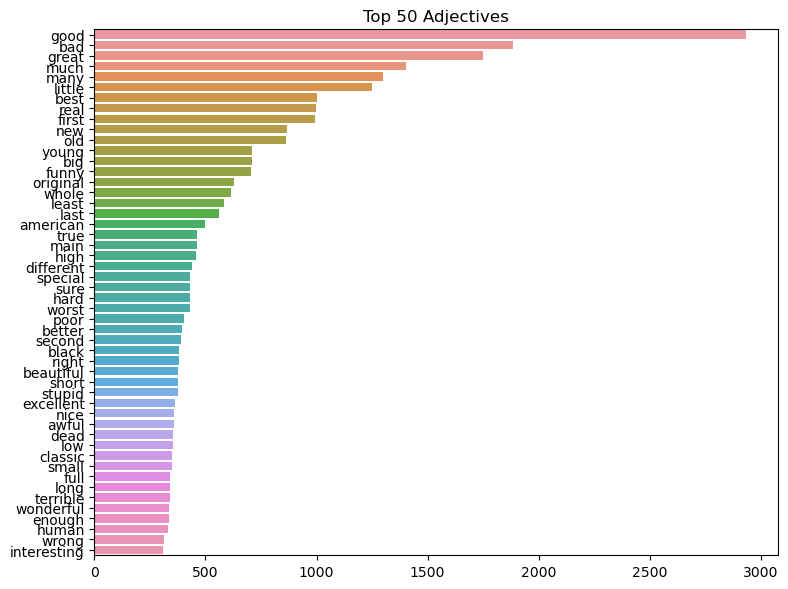

In [91]:
# Get most_common Adjectives
adj_word_pos, adj_freq_pos = get_most_common_pos(tags, 'ADJ', 50)
# plot the bar plot
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True
sns.barplot(x = pd.Series(adj_freq_pos), y = pd.Series(adj_word_pos))
plt.title('Top 50 Adjectives')
plt.show()

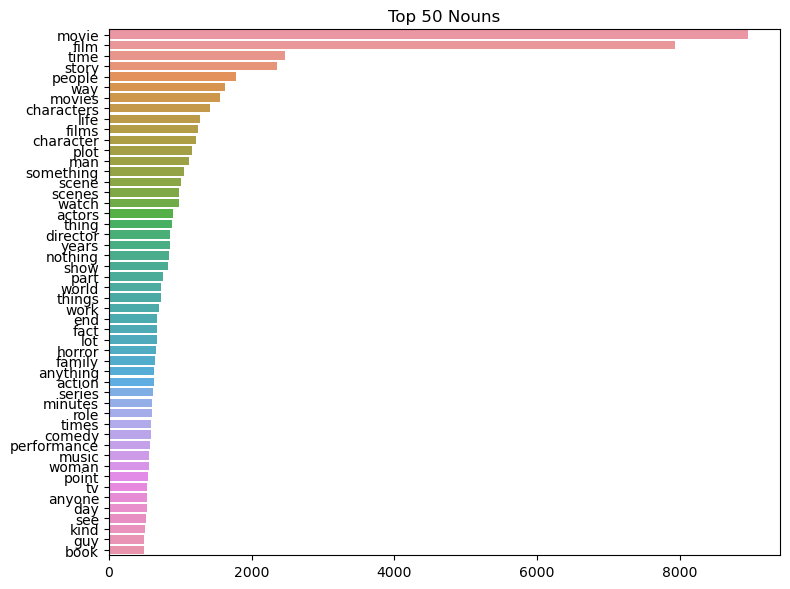

In [93]:
# Get Most common Nouns
noun_word_pos, noun_freq_pos = get_most_common_pos(tags, 'NOUN', 50)
# plot the bar plot
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True
sns.barplot(x = pd.Series(noun_freq_pos), y = pd.Series(noun_word_pos))
plt.title('Top 50 Nouns')
plt.show()

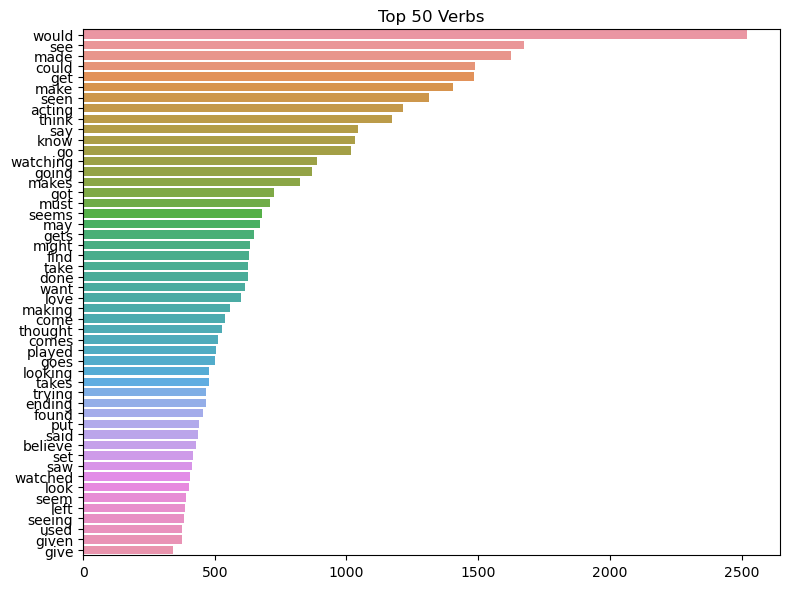

In [96]:
# Get Most common Verbs
verb_word_pos, verb_freq_pos = get_most_common_pos(tags, 'VERB', 50)
# plot the bar plot
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True
sns.barplot(x = pd.Series(verb_freq_pos), y = pd.Series(verb_word_pos))
plt.title('Top 50 Verbs')
plt.show()

### How a sentiment analysis library would perform on the dataset?

In [119]:
# measure polarity using text blob sentiment polarity
scores = measure_polarity(temp_df['review_nostopwords'])

<Axes: >

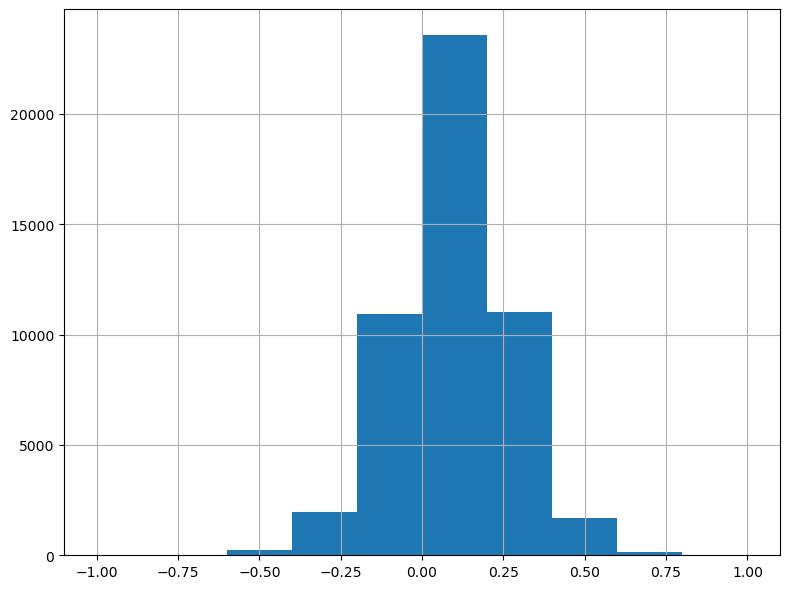

In [122]:
scores.hist()

- Most reviews have polarity between `-0.20` : `0.25`

In [120]:
temp_df['polarity_score'] = scores

<BarContainer object of 3 artists>

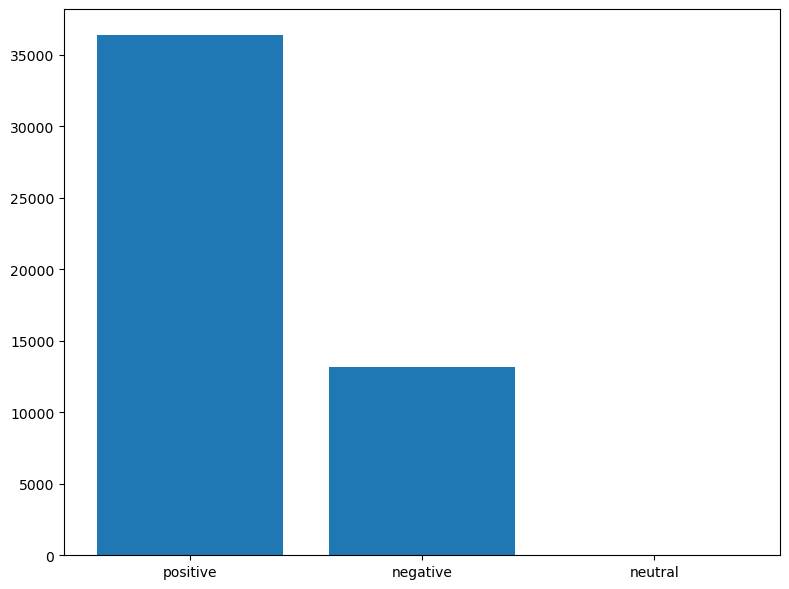

In [124]:
def sentiment(x):
    if x<0:
        return 'negative'
    elif x==0:
        return 'neutral'
    else:
        return 'positive'

temp_df['polarity']=temp_df['polarity_score'].map(lambda x: sentiment(x))

plt.bar(temp_df.polarity.value_counts().index,
        temp_df.polarity.value_counts())

In [125]:
accuracy=accuracy_score(temp_df['polarity'],temp_df['sentiment'])
print(accuracy)

0.7028760437255456


- If we assume the threshold at 0, Then the sentiment analysis library have 70% Accuracy

In [112]:
corr = scores.corr(temp_df['labels'].astype('float'), method=stats.pointbiserialr)

In [113]:
corr

SignificanceResult(statistic=0.5559157260737113, pvalue=0.0)

- It also has a positive correlation and statistically significant, It can be useful to use it as a new feature

## Feature Selection

In [41]:
sigma = featured_df.drop(['char_count'], axis = 1, level=1)

In [42]:
sigma = sigma.drop(['unique_words_count','stopwords_count'], axis = 1, level=1)

In [43]:
sigma = sigma.drop(['stopwords_percent'], axis = 1, level=1)

In [44]:
sigma = sigma.drop(['word_count'], axis = 1, level=1)

In [45]:
sigma = sigma.drop(['# count','+ count','= count','@ count', '[ count', '] count', '] count', '^ count', '_ count', '` count', '| count', '~ count'], axis = 1, level=1)

In [46]:
sigma = sigma.drop(['\ count'], axis = 1, level=1)

In [47]:
sigma = sigma.drop(['( count'], axis = 1, level=1)

In [48]:
sigma = sigma.drop(['( count','> count'], axis = 1, level=1)

In [49]:
sigma = sigma.drop(['( count'], axis = 1, level=1)

In [50]:
sigma = sigma.drop(['/ count'], axis = 1, level=1)

In [51]:
sigma = sigma.drop(['{ count'], axis = 1, level=1)

In [52]:
#calculate point-biserial correlation
prep_df['labels'] = prep_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
corr = sigma['punct_cols'].corrwith(prep_df['labels'].astype('float'), method=stats.pointbiserialr)
corr.rename(index={0: 'Correlation', 1: 'P_value'}, inplace=True)
corr = corr.style.format('{:.5f}')
corr

,! count,""" count",$ count,% count,& count,' count,) count,* count,", count",- count,. count,: count,; count,< count,? count,} count
Correlation,-0.01678,-0.02074,-0.04481,-0.01296,-0.01845,-0.04221,0.02156,-0.03105,0.03734,-0.01419,-0.03525,-0.01687,0.02179,-0.02275,-0.17089,0.01888
P_value,0.00019,0.00000,0.00000,0.00391,0.00004,0.00000,0.00000,0.00000,0.00000,0.00158,0.00000,0.00017,0.00000,0.00000,0.00000,0.00003


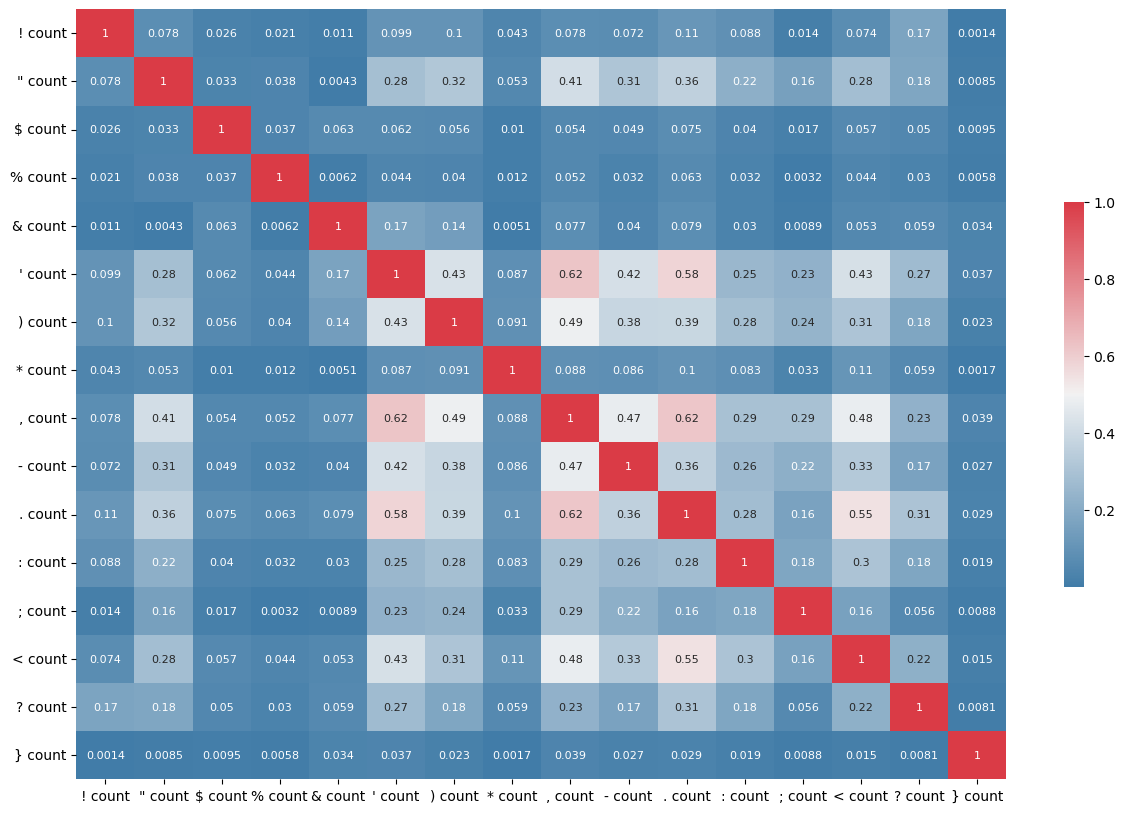

In [53]:
corr = sigma['punct_cols'].corr(numeric_only= True)
# plot the heatmap

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr, 
            cmap=sns.diverging_palette(240, 10, as_cmap=True),                        
            cbar_kws={"shrink": .5}, annot=True,annot_kws={"fontsize":8}
            )
# Save the figure
plt.show()

## Model Building

In [39]:
prep_df = pd.read_pickle(PREPROCESSED_PATH).reset_index(drop=True)

In [40]:
featured_df = pd.read_pickle(ENGINEERED_PATH)

### Intialize MLflow

In [54]:
# Create Directories
Path(MLFLOW_TRACKING_URI).mkdir(parents=True, exist_ok=True)
Path(LOG_PATH).mkdir(parents=True, exist_ok=True)

In [55]:
# Initialize client and experiment
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
client = MlflowClient()
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
exp = client.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)

### Create a Test set

In [232]:
# For NB

featured_df = sigma.copy()
featured_df = featured_df.drop(['polarity'],axis = 1,level=1)

In [233]:
# Get a list of the names of coulmns in featured_df
featured_cols = featured_df['featured_cols'].columns.tolist()
punct_cols = featured_df['punct_cols'].columns.tolist()
num_cols = featured_cols +  punct_cols
# Remove the multi_index from featured_df
featured_df = featured_df.droplevel(0,axis = 1).copy()
# Convert the sentiments to integer labels 
prep_df['labels'] = prep_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [234]:
# Merge the new features with the lemmatized reviews and labels
model_df = pd.concat([featured_df,prep_df[['review_cleaned','labels']]], axis= 1)
# model_df = prep_df[['review_cleaned','labels']]

In [235]:
# Split the Dataset, No need to stratify split since the dataset is balanced
x_train, x_test, y_train, y_test = train_test_split(model_df.drop(['labels'],axis=1),model_df['labels'] ,test_size = 0.20,random_state = 42)

In [236]:
y_train.value_counts()

labels
1    19906
0    19759
Name: count, dtype: int64

In [237]:
y_test.value_counts()

labels
1    4978
0    4939
Name: count, dtype: int64

### Feature Scaling and Transformation

In [238]:
featured_df

,sent_count,capital_char_count,words_in_quotes_count,avg_word_len,avg_sent_len,unique_words_percent,! count,""" count",$ count,% count,...,) count,* count,", count",- count,. count,: count,; count,< count,? count,} count
0,10,8,0,5.527157,31.300000,0.431310,0,0,0,0,...,1,0,26,0,26,0,0,6,0,0
1,7,2,0,6.050000,22.857143,0.487500,1,2,0,0,...,1,0,5,4,6,1,0,6,0,0
2,4,3,0,5.419162,41.750000,0.479042,0,6,0,0,...,2,0,6,1,6,1,0,4,1,0
3,6,3,0,5.375940,22.166667,0.383459,2,0,0,0,...,1,0,3,0,10,1,0,6,0,0
4,9,1,0,5.600877,25.333333,0.434211,0,2,0,0,...,0,0,12,0,15,0,0,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49577,8,3,0,4.964646,24.750000,0.338384,0,0,0,0,...,1,0,16,0,8,0,0,4,0,0
49578,3,3,0,5.603604,37.000000,0.468468,0,0,0,0,...,0,0,8,1,5,0,0,4,0,0
49579,6,5,0,5.338983,39.333333,0.402542,0,2,0,0,...,1,0,5,0,17,0,0,4,0,0
49580,8,0,0,5.703704,27.000000,0.500000,0,2,0,0,...,2,0,9,0,8,0,0,0,0,0


### Build the Transformation pipeline

In [249]:
# create pipeline for numerical attributes
num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                               # StandardScaler()
                            )
 
# create pipeline for Text attributes                            
vectorizer_pipeline = make_pipeline(CountVectorizer(ngram_range=(1,2)))

# Combine both num and vec pipeline using column transformer
full_pipeline = ColumnTransformer([
    # ("num", num_pipeline, num_cols),
    ("vectorizer", vectorizer_pipeline, 'review_cleaned')])

In [ ]:
# apply all transformations
x_train_pipe = full_pipeline.fit_transform(x_train)
x_train_pipe

### Create a Baseline Model

In [251]:
%%time
log_clf = LogisticRegression(max_iter=1000,solver='liblinear')
log_clf.fit(x_train_pipe, y_train)

CPU times: total: 4min 51s
Wall time: 1min 18s


LogisticRegression(max_iter=1000, solver='liblinear')

In [252]:
# apply transformation on the test set
x_test_pipe = full_pipeline.transform(x_test)

In [253]:
y_pred=log_clf.predict(x_test_pipe)

In [254]:
# model score
accuracy=accuracy_score(y_pred,y_test)
print(accuracy)

0.9078350307552687


In [255]:
# confusion matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[4436  503]
 [ 411 4567]]


In [246]:
recall= recall_score(y_test, y_pred, average="binary")
precision = precision_score(y_test, y_pred, average="binary")
f1 = f1_score(y_test, y_pred, average="binary")
print(f"precision: {precision}, Recall: {recall}, F1: {f1}")

precision: 0.8999606144151241, Recall: 0.9180393732422659, F1: 0.9089101034208433


In [247]:
scores={'accuracy' : accuracy,
        'precision' : precision,
        'recall' : recall,
        'f1': f1}

In [248]:
scores

{'accuracy': 0.9076333568619542,
 'precision': 0.8999606144151241,
 'recall': 0.9180393732422659,
 'f1': 0.9089101034208433}

In [204]:
# Log the model's dataset train and test indices
log_data(x_train,y_train,x_test,y_test)
# Log the model, model description
model = log_model(log_clf,'LogReG,BOW,1,2ngram,stop+nofeats')
# Log the model's train and test scores
log_metrics(scores, scores)
# track the model artifacts, validation scores with mlflow
track_model(model,scores)

### Random Forest Model

In [16]:
#Create a random forest classifier
rf_clf = RandomForestClassifier(n_jobs=-1,verbose=1,random_state=42)

rf_clf.fit(x_train_pipe, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.1min finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [17]:
# apply transformation on the test set
x_test_pipe = full_pipeline.transform(x_test)

In [18]:
y_pred=rf_clf.predict(x_test_pipe)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.0s finished


In [19]:
# model score
accuracy=accuracy_score(y_pred,y_test)
print(accuracy)

0.8545931229202379


In [20]:
# confusion matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[4162  777]
 [ 665 4313]]


In [21]:
recall= recall_score(y_test, y_pred, average="binary")
precision = precision_score(y_test, y_pred, average="binary")
f1 = f1_score(y_test, y_pred, average="binary")
print(f"precision: {precision}, Recall: {recall}, F1: {f1}")

precision: 0.8473477406679765, Recall: 0.8664122137404581, F1: 0.8567739372268574


In [22]:
scores={'accuracy' : accuracy,
        'precision' : precision,
        'recall' : recall,
        'f1': f1}

In [23]:
scores

{'accuracy': 0.8545931229202379,
 'precision': 0.8473477406679765,
 'recall': 0.8664122137404581,
 'f1': 0.8567739372268574}

In [24]:
# Log the model's dataset train and test indices
log_data(x_train,y_train,x_test,y_test)
# Log the model, model description
model = log_model(rf_clf,'rf_clf,BOW,1,2ngram, stop+feats')
# Log the model's train and test scores
log_metrics(scores, scores)
# track the model artifacts, validation scores with mlflow
track_model(model,scores)

### Naive-Bayes Classifier

In [126]:
from sklearn.naive_bayes import MultinomialNB

# initialize naive bayes model
nb_clf = MultinomialNB()
# fit the model on training data reviews and sentiment
nb_clf.fit(x_train_pipe, y_train)

ValueError: Negative values in data passed to MultinomialNB (input X)

In [127]:
# apply transformation on the test set
x_test_pipe = full_pipeline.transform(x_test)

In [107]:
y_pred=nb_clf.predict(x_test_pipe)

In [108]:
# model score
accuracy=accuracy_score(y_pred,y_test)
print(accuracy)

0.8822224463043259


In [109]:
# confusion matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[4423  516]
 [ 652 4326]]


In [110]:
recall= recall_score(y_test, y_pred, average="binary")
precision = precision_score(y_test, y_pred, average="binary")
f1 = f1_score(y_test, y_pred, average="binary")
print(f"precision: {precision}, Recall: {recall}, F1: {f1}")

precision: 0.8934324659231723, Recall: 0.8690237042989152, F1: 0.8810590631364562


In [111]:
scores={'accuracy' : accuracy,
        'precision' : precision,
        'recall' : recall,
        'f1': f1}

In [112]:
scores

{'accuracy': 0.8822224463043259,
 'precision': 0.8934324659231723,
 'recall': 0.8690237042989152,
 'f1': 0.8810590631364562}

In [113]:
# Log the model's dataset train and test indices
log_data(x_train,y_train,x_test,y_test)
# Log the model, model description
model = log_model(nb_clf,'nb_clf,Bow,1,2ngram, stop,featsfullclean')
# Log the model's train and test scores
log_metrics(scores, scores)
# track the model artifacts, validation scores with mlflow
track_model(model,scores)

### Hyperparameter Tuning the Best Model

### Try Ensemble methods

### Analyze the Best Models and their Errors

### Evaluate your System on the Test Set

### Import the Best Model

## Retrieve Runs

In [205]:
runs = mlflow.search_runs([exp.experiment_id])
runs[['run_id','tags.mlflow.runName','metrics.precision','metrics.recall','metrics.f1','metrics.accuracy']]

,run_id,tags.mlflow.runName,metrics.precision,metrics.recall,metrics.f1,metrics.accuracy
0,ce3f027820924c53a01017397ad1f270,"LogReG,BOW,1,2ngram,stop+nofeats",0.900789,0.917437,0.909037,0.907835
1,5c2eac23a3724400b4b2d43b8329e524,"LogReG,BOW,1,2ngram,stop+nofeats",0.900789,0.917437,0.909037,0.907835
2,c7d6a97a458541d4bf3340e5ba0d5221,"LogReG,BOW,1,2ngram,stop+featsfullClnNopolarity",0.900947,0.917236,0.909019,0.907835
3,ea4d0a1621c14513951e17c0b3d872de,"Base:Log ReG,BOW,1,2ngram,stop+featsfullclean",0.898717,0.914423,0.906502,0.905314
4,2788fd663aae44da9bd9f849b00982d1,"Base:Log ReG,BOW,1,2ngram,stop+featsfullclean",0.898697,0.914223,0.906393,0.905213
5,102cd6c75fab4e3a87e9a16cb1ea85e1,"Base:Log ReG,BOW,1,2ngram,stop+featsClean1",0.898717,0.914423,0.906502,0.905314
6,3f83af7da01149dc988fe0754c65cb28,"nb_clf,TF,1,3ngram, nostop",0.878149,0.903375,0.890583,0.888575
7,eb27e1daebe044deb612a9f874826ea0,"nb_clf,TF,1,2ngram, lemma",0.880543,0.885496,0.883013,0.882222
8,7eb1fe77680f421ea3134265e497d444,"nb_clf,TF,1,2ngram, stop",0.901957,0.879671,0.890674,0.891600
9,ea5fd6f9a7b14517b64c68c8139e7e78,"nb_clf,BOW,1,2ngram, stop+feat",0.888684,0.872439,0.880487,0.881113
